Imports 

In [6]:
import argparse, yaml
from experiments.base_experiment import BaseExperiment
import numpy as np
from matplotlib import pyplot as plt

ExperimentFactory calss 

In [2]:
class ExperimentFactory:
    @staticmethod
    def create_experiment(config) -> BaseExperiment:
        # create and return the corresponding experiment instance based on config
        experiment_type = config['experiment']['type']
        if experiment_type == 'gaussian_classification':
            from experiments.gaussian_classification_experiment import GaussianClassificationExperiment
            return GaussianClassificationExperiment(config)
        elif experiment_type == 'mnist_classification':
            from experiments.mnist_classification_experiment import MnistClassificationExperiment
            return MnistClassificationExperiment(config)
        else:
            raise ValueError(f"Unknown experiment type: {experiment_type}")

Reading the config file and creating the experiment instance 

In [3]:
config_path = "configs/gaussian_config.yaml"

with open(config_path, 'r') as f:
    config = yaml.safe_load(f)
    
exp = ExperimentFactory.create_experiment(config)

Initialized GaussianClassificationExperiment.
Using CPU for evaluation.
Created the model: MLP(
  (net): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=False)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Linear(in_features=10, out_features=2, bias=False)
    (3): LeakyReLU(negative_slope=0.1)
  )
)
Created test dataset with 10000 samples.
Created test DataLoader.


***1) Estimate classifier density D(E) (left plot)***

Estimating classifier density D(E) with 1000000 trials.


100%|██████████| 1000000/1000000 [03:36<00:00, 4626.84it/s]


Estimating classifier density completed.


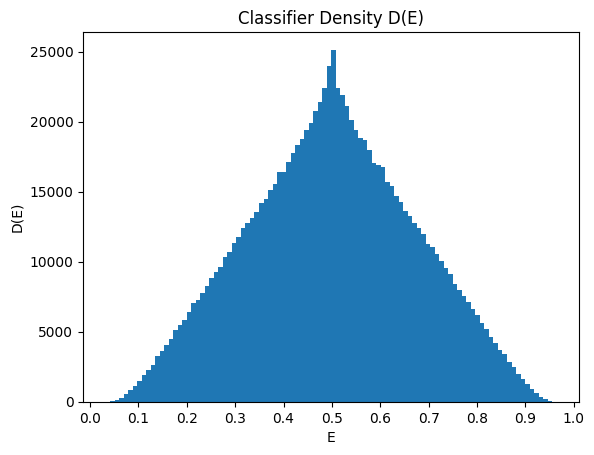

In [ ]:
# ---------------------------------------------
# 1) Estimate classifier density D(E) (left plot)
# ---------------------------------------------
exp.logger.log(f"Estimating classifier density D(E) with {exp.doc_config['n_trials']} trials.")
true_errors = exp.estimate_classifier_density()
exp.logger.save_numpy_array(np.array(true_errors), "classifier_density.npy")
exp.logger.log(f"Estimating classifier density completed.")
hist_fig, _ = exp.plotter.plot_histogram(data=true_errors,
                                            bins=exp.doc_config['histogram_bins'],
                                            title = "Classifier Density D(E)",
                                            xlabel = "E",
                                            ylabel = "D(E)")
exp.logger.save_figure(hist_fig, "classifier_density_histogram.png")
plt.figure(hist_fig)   # activate the figure
plt.show()